# Cell Instance Segmentation using DinoBloom Foundation Model
This notebook demonstrates how to train and evaluate a cell segmentation model using DinoBloom as a frozen backbone.

- Author: Chunrui Zou
- Date: February 2026
- Assignment: Merck Pre-Interview Coding Assignment



## Notebook Structure
1. Setup & Imports
2. Data Loading & Exploration
3. Model Definition
4. Training
5. Evaluation on Test Set
6. Inference Demo (Single Image)
7. Pre-trained Results (Optional - Show our best results)

## 1. Setup & Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import json

# Setup paths
NOTEBOOK_DIR = Path.cwd()
CODES_DIR = NOTEBOOK_DIR / "Codes"
sys.path.insert(0, str(CODES_DIR))

# Import custom modules
from backbone import load_dinobloom, extract_features, IMAGENET_MEAN, IMAGENET_STD
from data import BCCDDataset, create_datasets, create_test_dataset, get_collate_fn
from data.splits import create_train_val_split, load_split
from models import CellSegmentor
from training import Trainer, BCEDiceLoss
from evaluation.metrics import SegmentationMetrics, compute_per_image_metrics
from evaluation.visualize import visualize_prediction

In [3]:
# Paths
DATA_ROOT = NOTEBOOK_DIR / "Data" / "BCCD"
OUTPUT_DIR = CODES_DIR / "outputs" / "training" / "notebook_experiment"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Device
# The device is default to CPU since our training and setup were tested using a CPU-only laptop
# Set to True only if you want to run on GPU
ENABLE_GPU = False 

if ENABLE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

print(f"Using device: {device}")
print(f"Data root: {DATA_ROOT}")
print(f"Output dir: {OUTPUT_DIR}")

Running on CPU
Using device: cpu
Data root: D:\A_Jobs\Merck\Fd-To-Sg\Data\BCCD
Output dir: D:\A_Jobs\Merck\Fd-To-Sg\Codes\outputs\training\notebook_experiment


## Data Loading & Exploration

In [4]:
# Change import
from data.splits import create_train_val_split, load_split

# Change the split creation code:
SPLIT_PATH = DATA_ROOT / "splits.json"

if not SPLIT_PATH.exists():
  print("Creating new train/val split...")
  train_files, val_files = create_train_val_split(
      image_dir=DATA_ROOT / "train" / "original",
      output_path=SPLIT_PATH,
      val_ratio=0.2,
      seed=42
  )
  print(f"Split saved to {SPLIT_PATH}")
else:
  print(f"Loading existing split from {SPLIT_PATH}")
  train_files, val_files = load_split(SPLIT_PATH)

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

Loading existing split from D:\A_Jobs\Merck\Fd-To-Sg\Data\BCCD\splits.json
Training samples: 936
Validation samples: 233


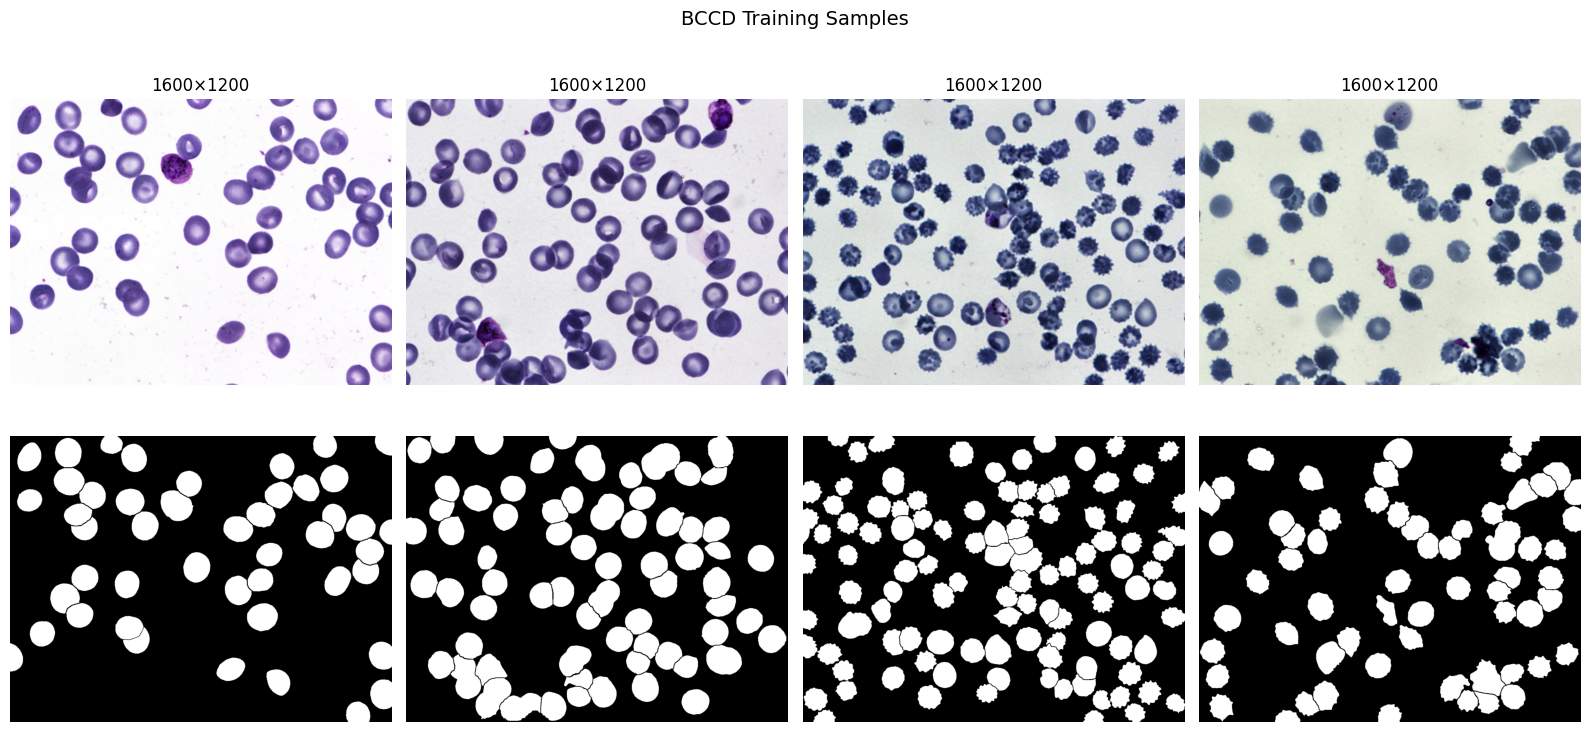

In [5]:
# Visualize a few training samples
train_dir = DATA_ROOT / "train"
sample_files = train_files[:4]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, fname in enumerate(sample_files):
    # Load image
    img_path = train_dir / "original" / fname
    img = Image.open(img_path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"{img.size[0]}×{img.size[1]}")
    axes[0, i].axis("off")

    # Load mask
    mask_name = Path(fname).stem + ".png"
    mask_path = train_dir / "mask" / mask_name
    if mask_path.exists():
        mask = Image.open(mask_path)
        axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Image", fontsize=12)
axes[1, 0].set_ylabel("Mask", fontsize=12)
plt.suptitle("BCCD Training Samples", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
# Training configuration
BATCH_SIZE = 8
TILE_SIZE = 224
OVERLAP = 0.5

# Create datasets
train_dataset, val_dataset = create_datasets(
    data_root=DATA_ROOT,
    split_path=SPLIT_PATH,
    mode="tiling",
    tile_size=TILE_SIZE,
    overlap=OVERLAP,
    val_random_crop=True  # Use random crops for validation during training
)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=get_collate_fn("tiling", train=True)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=get_collate_fn("tiling", train=True)
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train dataset: 936 samples
Val dataset: 233 samples
Train batches: 117
Val batches: 30


Batch keys: dict_keys(['images', 'masks', 'positions', 'filenames', 'original_sizes'])
Images shape: torch.Size([8, 3, 224, 224])
Masks shape: torch.Size([8, 224, 224])


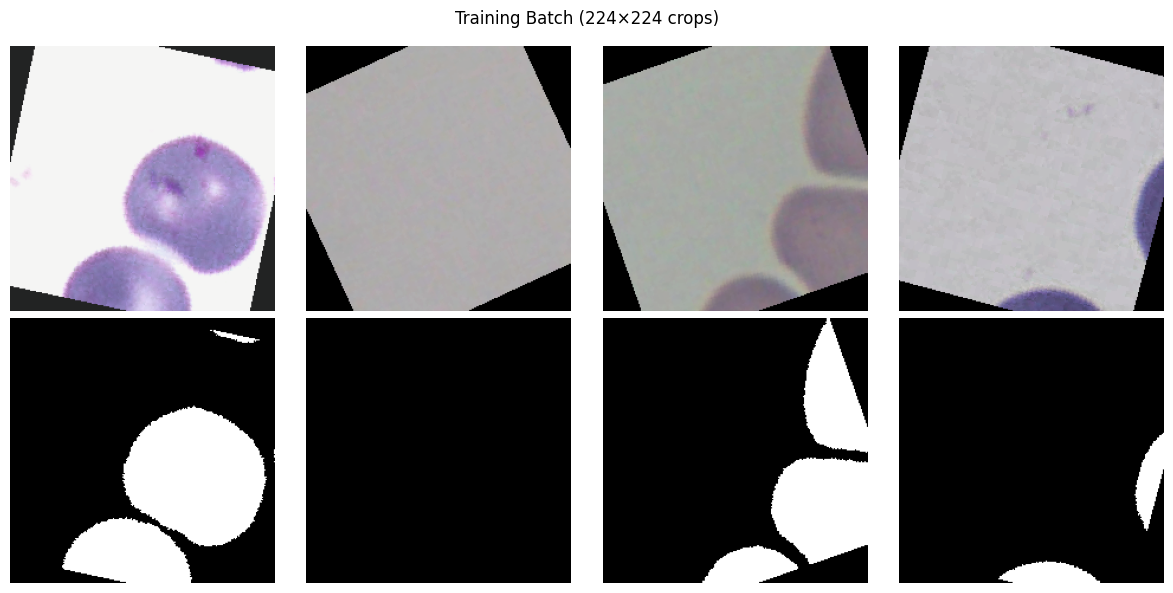

In [7]:
# Verify a batch for data loader with augmentation
batch = next(iter(train_loader))
print(f"Batch keys: {batch.keys()}")
print(f"Images shape: {batch['images'].shape}")
print(f"Masks shape: {batch['masks'].shape}")

# Visualize a batch sample
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(min(4, batch['images'].shape[0])):
    img = batch['images'][i].permute(1, 2, 0).numpy()
    # Denormalize
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    mask = batch['masks'][i].numpy()

    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[1, i].imshow(mask, cmap="gray")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Image")
axes[1, 0].set_ylabel("Mask")
plt.suptitle("Training Batch (224×224 crops)", fontsize=12)
plt.tight_layout()
plt.show()

## Model Definition

We use **DinoBloom-S** (Small) as a frozen backbone with a trainable segmentation head.

- **Backbone**: DinoBloom-S 
- **Head**: Transposed Convolution Decoder (one of the headers, we use it since it balance capacity and complexity
- **Output**: 2-class segmentation (background, cell)

In [8]:
# Create model
# You might get warning for xFormer, safe to ignore it.
model = CellSegmentor(
    backbone_size="small",
    num_classes=2,
    head_type="transposed_conv",
    freeze_backbone=True
).to(device)

Loading DinoBloom-SMALL (22M params)...


Using cache found in C:\Users\chunr/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\chunr/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\chunr/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\chunr/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded. Embed dim: 384


In [9]:
# Parameter summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
print(f"Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")

Total parameters: 22,611,330
Trainable parameters: 982,146 (4.3%)
Frozen parameters: 21,629,184 (95.7%)


In [10]:
# Test forward pass
model.eval()
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = model(dummy_input)
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 2, 224, 224])


## 4. Training

### Training Configuration
The training configuration is empirically determined (not enough time to integrate automatic tuning).

| Parameter | Value |
|-----------|-------|
| Epochs | 50 (mostly enough, you can increase the number if not enough) |
| Batch Size | 8 |
| Learning Rate | 1e-4 |
| Optimizer | AdamW |
| Scheduler | Cosine Annealing |
| Loss | BCE + Dice (0.5 each) |
| Early Stopping | 10 epochs patience |

In [11]:
# Training hyperparameters
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 10

# Loss function
criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS
)

print("Training setup complete:")
print(f"  Loss: BCEDiceLoss (bce=0.5, dice=0.5)")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")
print(f"  Scheduler: CosineAnnealingLR (T_max={NUM_EPOCHS})")

Training setup complete:
  Loss: BCEDiceLoss (bce=0.5, dice=0.5)
  Optimizer: AdamW (lr=0.0001, wd=0.0001)
  Scheduler: CosineAnnealingLR (T_max=5)


In [12]:
# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    checkpoint_dir=OUTPUT_DIR
)

print(f"Trainer created. Checkpoints will be saved to: {OUTPUT_DIR}")

Trainer created. Checkpoints will be saved to: D:\A_Jobs\Merck\Fd-To-Sg\Codes\outputs\training\notebook_experiment


In [21]:
# Train the model
# NOTE: Set NUM_EPOCHS to a small value (e.g., 2-3) for quick testing
#       Set to 50 for full training

history = trainer.fit(
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

print("\nTraining complete!")
print(f"Best validation loss: {trainer.best_val_loss:.4f}")

Starting training for 5 epochs...
  Device: cpu
  Train batches: 117
  Val batches: 30

    Batch 10/117: loss=0.4581
    Batch 20/117: loss=0.3901
    Batch 30/117: loss=0.3349
    Batch 40/117: loss=0.3528
    Batch 50/117: loss=0.3581
    Batch 60/117: loss=0.2399
    Batch 70/117: loss=0.3018
    Batch 80/117: loss=0.2665
    Batch 90/117: loss=0.2187
    Batch 100/117: loss=0.2015
    Batch 110/117: loss=0.2084
Epoch   1/5 | train_loss: 0.2966 | train_dice: 0.9193 | val_loss: 0.2083 | val_dice: 0.9561 | lr: 1.00e-04 | time: 240.7s
  Saved checkpoint: D:\A_Jobs\Merck\Fd-To-Sg\Codes\outputs\training\notebook_experiment\best.pth
    Batch 10/117: loss=0.1973
    Batch 20/117: loss=0.2143
    Batch 30/117: loss=0.1960
    Batch 40/117: loss=0.1822
    Batch 50/117: loss=0.1909
    Batch 60/117: loss=0.2020
    Batch 70/117: loss=0.2123
    Batch 80/117: loss=0.1653
    Batch 90/117: loss=0.1684
    Batch 100/117: loss=0.2213
    Batch 110/117: loss=0.2095
Epoch   2/5 | train_loss: 0.2

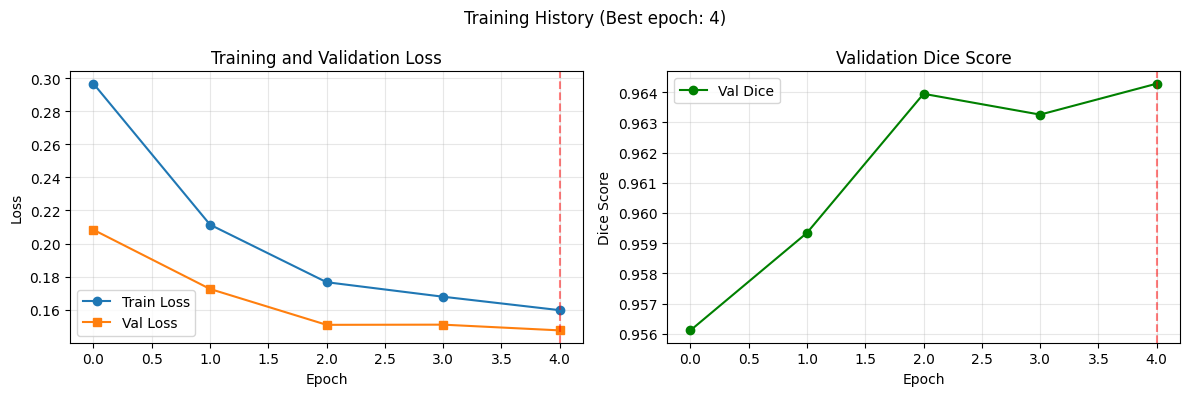

Best epoch: 4
  Val loss: 0.1475
  Val dice: 0.9643


In [22]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train Loss", marker="o")
axes[0].plot(history["val_loss"], label="Val Loss", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice
axes[1].plot(history["val_dice"], label="Val Dice", marker="o", color="green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Score")
axes[1].set_title("Validation Dice Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Mark best epoch
best_epoch = np.argmin(history["val_loss"])
axes[0].axvline(best_epoch, color="red", linestyle="--", alpha=0.5)
axes[1].axvline(best_epoch, color="red", linestyle="--", alpha=0.5)

plt.suptitle(f"Training History (Best epoch: {best_epoch})", fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_curves.png", dpi=150)
plt.show()

print(f"Best epoch: {best_epoch}")
print(f"  Val loss: {history['val_loss'][best_epoch]:.4f}")
print(f"  Val dice: {history['val_dice'][best_epoch]:.4f}")

## 5. Evaluation on Test Set

We evaluate the trained model on the held-out test set (159 images) using:
- IoU (Intersection over Union)
- Dice Score
- Precision & Recall
- Pixel Accuracy

In [13]:
# Load best checkpoint
checkpoint_path = OUTPUT_DIR / "best.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")
print(f"Validation Dice: {checkpoint['metrics']['val_dice']:.4f}")

Loaded checkpoint from epoch 5
Best validation loss: 0.1475
Validation Dice: 0.9643


In [14]:
###  Create Test Dataset
from data.tiling import stitch_tiles

# Create test dataset with full tiling for inference
test_dataset = create_test_dataset(
    data_root=DATA_ROOT,
    mode="tiling",
    tile_size=TILE_SIZE,
    overlap=OVERLAP
)

print(f"Test dataset: {len(test_dataset)} images")



Test dataset: 159 images
Test dataset: 159 images
Evaluating: 10 images (subset)


In [21]:
# Evaluation on test set

# Configuration: number of samples to evaluate
# Inference implement full tilings which takes time for each image. 
# Instead, NUM_EVAL_SAMPLES can set the number of images to be tested on
# Set to None for full dataset (159 images), or a number for quick testing
#NUM_EVAL_SAMPLES = None  # Options: None (all), 10, 20, etc.
NUM_EVAL_SAMPLES = 3 # switch to None to test on the full testset, decrease the number if taking too much time
num_samples = len(test_dataset) if NUM_EVAL_SAMPLES is None else min(NUM_EVAL_SAMPLES, len(test_dataset))
print(f"Test dataset: {len(test_dataset)} images")
print(f"Evaluating: {num_samples} images" + (" (full dataset)" if NUM_EVAL_SAMPLES is None else " (subset)"))

metrics_calculator = SegmentationMetrics(num_classes=2)
all_metrics = []

model.eval()
with torch.no_grad():
  for idx in tqdm(range(num_samples), desc="Evaluating"):
      sample = test_dataset[idx]

      # Get tiles and metadata
      tiles = sample["tiles"].to(device)
      positions = sample["positions"]
      original_size = sample["original_size"]
      mask = sample["mask"]

      # Forward pass on all tiles
      outputs = model(tiles)
      probs = torch.softmax(outputs, dim=1)[:, 1]  # Cell probability

      # Stitch tiles back together
      stitched = stitch_tiles(
          tiles=probs.cpu().numpy(),
          positions=positions,
          output_size=(original_size[0], original_size[1]),
          tile_size=TILE_SIZE
      )

      # Threshold to get prediction
      prediction = (stitched > 0.5).astype(np.uint8)

      # Calculate metrics for this image
      # Note: mask from dataset is already binary (0.0/1.0 float tensor)
      mask_binary = mask.numpy().astype(np.uint8)

      metrics_calculator.update(
          torch.tensor(prediction).unsqueeze(0),
          torch.tensor(mask_binary).unsqueeze(0)
      )

      # Store per-image metrics
      per_img = compute_per_image_metrics(
          torch.tensor(prediction),
          torch.tensor(mask_binary)
      )
      all_metrics.append({
          "filename": sample.get("filename", f"sample_{idx}"),
          "iou": per_img["iou_cell"],
          "dice": per_img["dice_cell"]
      })

# Compute final metrics
final_metrics = metrics_calculator.compute()
print("\n" + "="*50)
print(f"TEST SET EVALUATION RESULTS ({num_samples}/{len(test_dataset)} images)")
print("="*50)
print(f"{'Metric':<20} {'Value':>10}")
print("-"*50)
print(f"{'Cell IoU':<20} {final_metrics['iou_cell']:>10.4f}")
print(f"{'Cell Dice':<20} {final_metrics['dice_cell']:>10.4f}")
print(f"{'Precision':<20} {final_metrics['precision_cell']:>10.4f}")
print(f"{'Recall':<20} {final_metrics['recall_cell']:>10.4f}")
print(f"{'Accuracy':<20} {final_metrics['accuracy']:>10.4f}")
print("="*50)


Test dataset: 159 images
Evaluating: 3 images (subset)


Evaluating: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [02:12<00:00, 44.33s/it]


TEST SET EVALUATION RESULTS (3/159 images)
Metric                    Value
--------------------------------------------------
Cell IoU                 0.9013
Cell Dice                0.9481
Precision                0.9231
Recall                   0.9744
Accuracy                 0.9706


In [22]:
# Save metrics
eval_dir = OUTPUT_DIR / "evaluation"
eval_dir.mkdir(exist_ok=True)

with open(eval_dir / "metrics.json", 'w') as f:
    json.dump(final_metrics, f, indent=2)

with open(eval_dir / "per_image_metrics.json", 'w') as f:
    json.dump(all_metrics, f, indent=2)

print(f"Metrics saved to {eval_dir}")

Metrics saved to D:\A_Jobs\Merck\Fd-To-Sg\Codes\outputs\training\notebook_experiment\evaluation


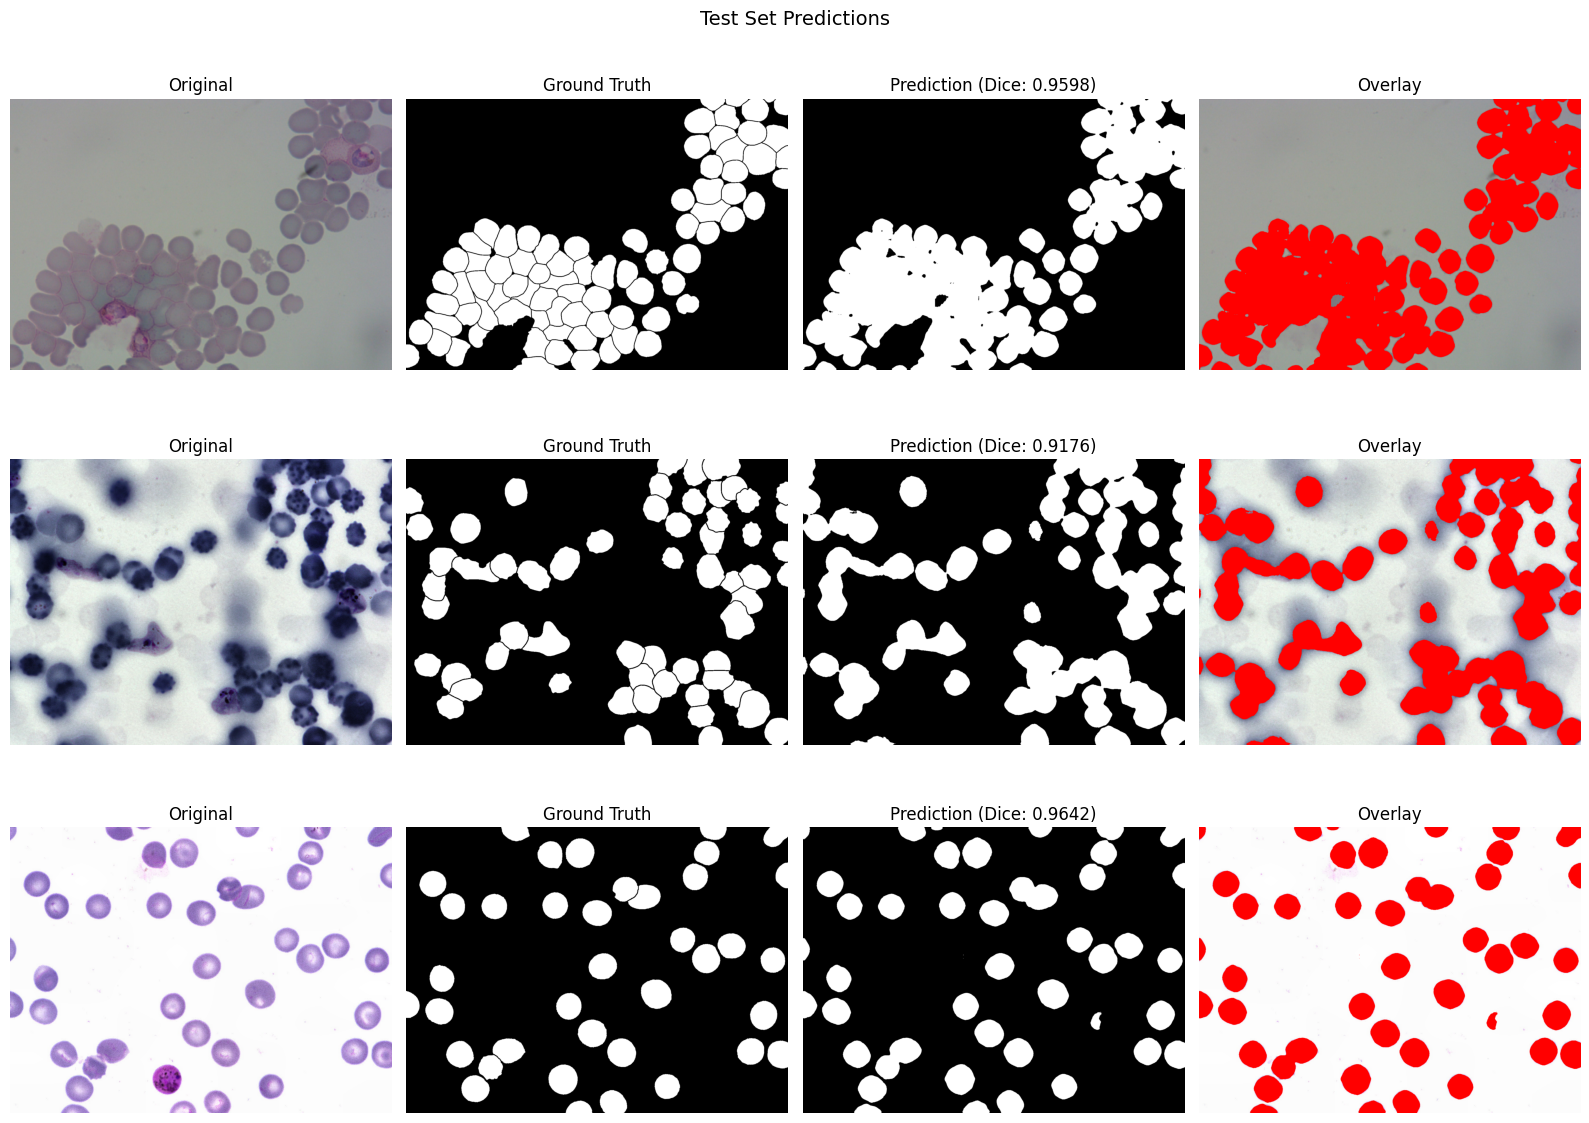

In [23]:
# Visualize some test predictions
num_vis = min(4, num_samples)  # Don't visualize more than we evaluated
fig, axes = plt.subplots(num_vis, 4, figsize=(16, 4*num_vis))

# Path to test images
test_image_dir = DATA_ROOT / "test" / "original"

for idx in range(num_vis):
    sample = test_dataset[idx]

    # Get prediction
    tiles = sample["tiles"].to(device)
    positions = sample["positions"]
    original_size = sample["original_size"]

    with torch.no_grad():
        outputs = model(tiles)
        probs = torch.softmax(outputs, dim=1)[:, 1]

    stitched = stitch_tiles(
        tiles=probs.cpu().numpy(),
        positions=positions,
        output_size=(original_size[0], original_size[1]),
        tile_size=TILE_SIZE
    )
    prediction = (stitched > 0.5).astype(np.uint8)

    # Load original image from disk
    filename = sample["filename"]
    original_img = Image.open(test_image_dir / filename).convert("RGB")
    original_img = np.array(original_img)

    # Get mask (already a tensor from dataset)
    mask = sample["mask"].numpy()
    mask_binary = (mask > 0.5).astype(np.uint8)

    # Calculate dice for this sample
    dice = all_metrics[idx]["dice"]

    # Plot
    axes[idx, 0].imshow(original_img)
    axes[idx, 0].set_title("Original")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(mask_binary, cmap="gray")
    axes[idx, 1].set_title("Ground Truth")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(prediction, cmap="gray")
    axes[idx, 2].set_title(f"Prediction (Dice: {dice:.4f})")
    axes[idx, 2].axis("off")

    # Overlay
    overlay = original_img.copy()
    overlay[prediction == 1] = [255, 0, 0]  # Red for predicted cells
    axes[idx, 3].imshow(overlay)
    axes[idx, 3].set_title("Overlay")
    axes[idx, 3].axis("off")

plt.suptitle("Test Set Predictions", fontsize=14)
plt.tight_layout()
plt.savefig(eval_dir / "test_predictions.png", dpi=150)
plt.show()

## 6. Inference Demo (Single Image)

Demonstrate inference on a single image from the test set.

Running inference on: e02301ac-68f7-4daf-b2ba-254b917f1cca.jpg


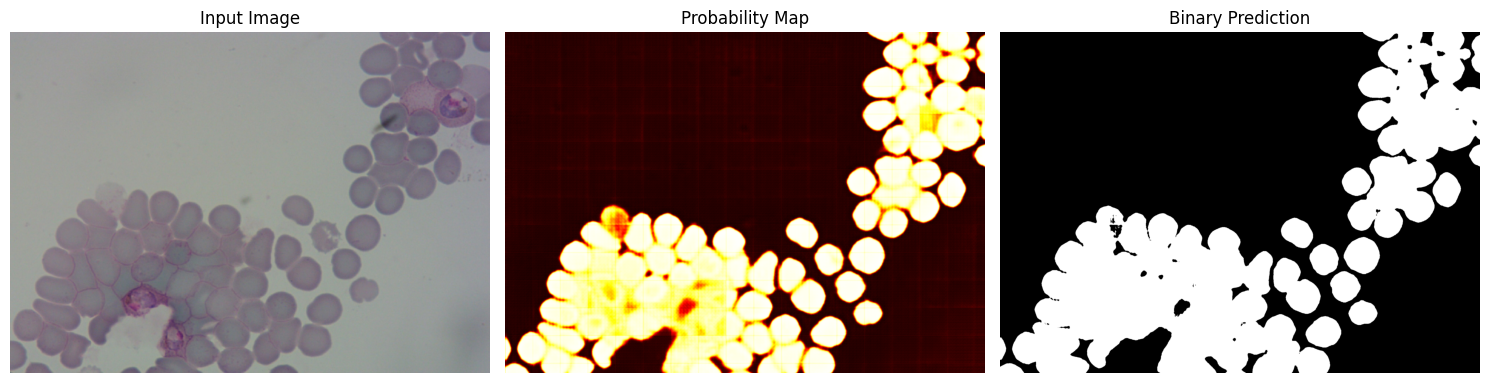

In [25]:
def predict_single_image(model, image_path, tile_size=224, overlap=0.5, device="cpu"):
    """Run inference on a single image."""
    from data.tiling import extract_tiles, calculate_tile_positions, stitch_tiles, pad_to_multiple
    from data.transforms import get_normalize_transform

    # Load image
    img = Image.open(image_path).convert("RGB")
    img_array = np.array(img)

    # Pad to multiple of tile_size
    img_pil = Image.fromarray(img_array)
    padded_img, padding = pad_to_multiple(img_pil, tile_size)

    # Calculate tile positions
    positions, grid_size = calculate_tile_positions(
        image_size=padded_img.size,
        tile_size=tile_size,
        overlap=overlap
    )

    # Extract tiles
    tiles = extract_tiles(padded_img, positions, tile_size)

    # Normalize tiles
    normalize = get_normalize_transform()
    tiles_tensor = torch.stack([normalize(tile) for tile in tiles])

    # Run inference
    model.eval()
    with torch.no_grad():
        tiles_tensor = tiles_tensor.to(device)
        outputs = model(tiles_tensor)
        probs = torch.softmax(outputs, dim=1)[:, 1]

    # Stitch
    stitched = stitch_tiles(
        tiles=probs.cpu().numpy(),
        positions=positions,
        output_size=padded_img.size,
        tile_size=tile_size
    )

    # Remove padding - crop to original image size
    stitched = stitched[:img.size[1], :img.size[0]]

    prediction = (stitched > 0.5).astype(np.uint8)

    return prediction, stitched

# Demo on a test image
test_image_path = list((DATA_ROOT / "test" / "original").glob("*"))[0]
print(f"Running inference on: {test_image_path.name}")

prediction, prob_map = predict_single_image(model, test_image_path, device=device)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img = Image.open(test_image_path)
axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(prob_map, cmap="hot")
axes[1].set_title("Probability Map")
axes[1].axis("off")

axes[2].imshow(prediction, cmap="gray")
axes[2].set_title("Binary Prediction")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## 7. Pre-trained Results (Our Best Model from SINGLE Run)
Below we show the results from our best trained model (trained for 20 epochs, best checkpoint at epoch 13).

In [26]:
# Path to our pre-trained model results
PRETRAINED_DIR = CODES_DIR / "outputs" / "training" / "tiling_transposed_conv_20260203_203221"

# Load metrics
pretrained_metrics_path = PRETRAINED_DIR / "evaluation" / "metrics.json"
if pretrained_metrics_path.exists():
    with open(pretrained_metrics_path) as f:
        pretrained_metrics = json.load(f)

    print("="*50)
    print("PRE-TRAINED MODEL RESULTS (Test Set: 159 images)")
    print("="*50)
    print(f"{'Metric':<20} {'Value':>10}")
    print("-"*50)
    print(f"{'Cell IoU':<20} {pretrained_metrics['iou_cell']:>10.4f}")
    print(f"{'Cell Dice':<20} {pretrained_metrics['dice_cell']:>10.4f}")
    print(f"{'Precision':<20} {pretrained_metrics['precision_cell']:>10.4f}")
    print(f"{'Recall':<20} {pretrained_metrics['recall_cell']:>10.4f}")
    print(f"{'Accuracy':<20} {pretrained_metrics['accuracy']:>10.4f}")
    print("="*50)
else:
    print(f"Pre-trained metrics not found at {pretrained_metrics_path}")

PRE-TRAINED MODEL RESULTS (Test Set: 159 images)
Metric                    Value
--------------------------------------------------
Cell IoU                 0.9112
Cell Dice                0.9536
Precision                0.9396
Recall                   0.9680
Accuracy                 0.9709


Success Case (High Dice: 0.9761):


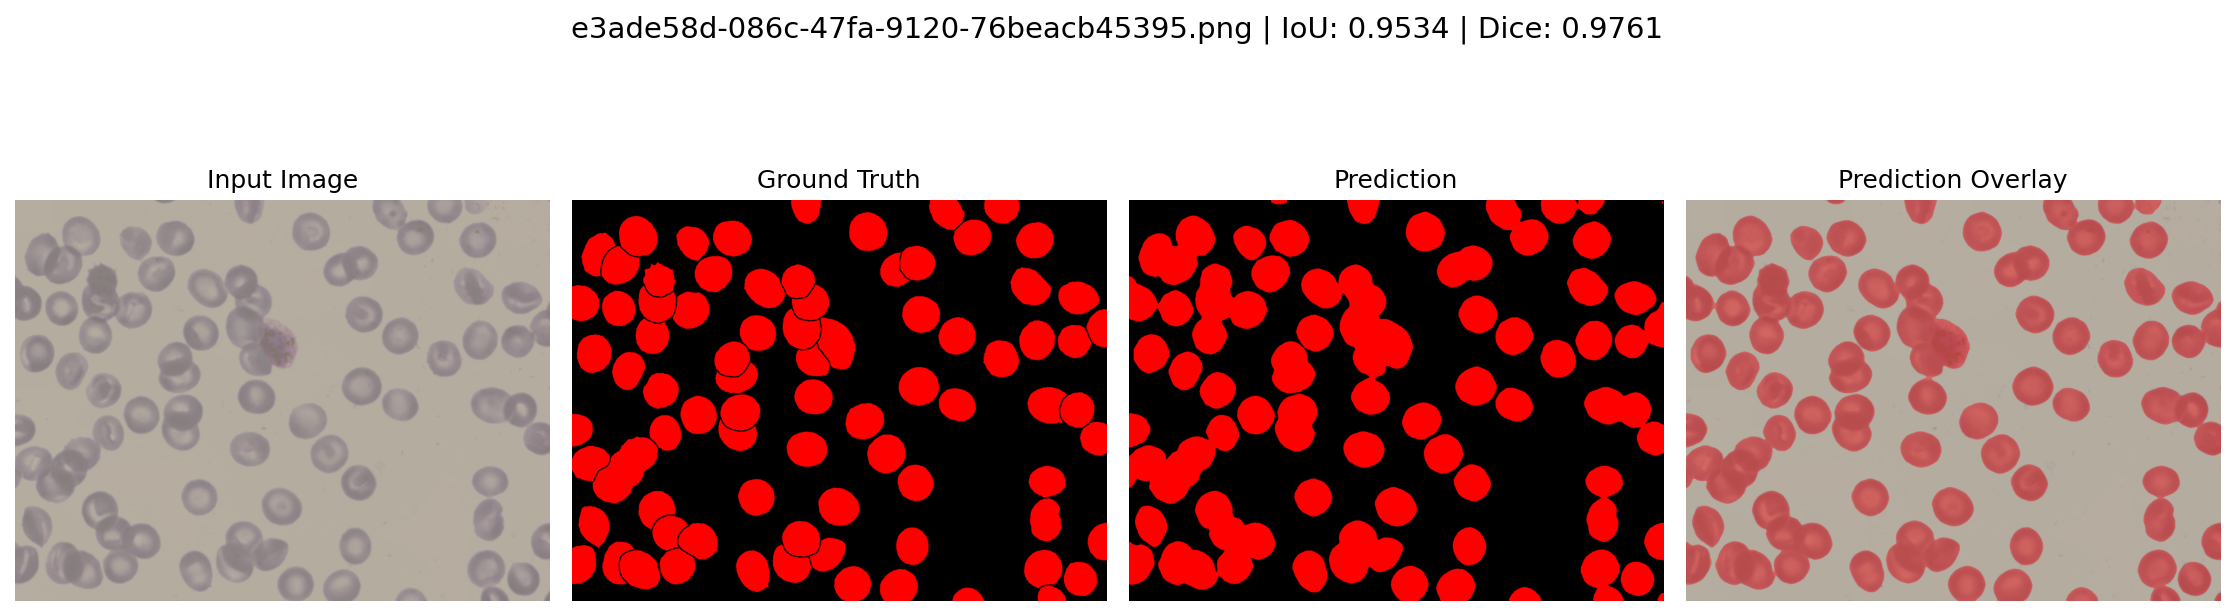


Challenging Case (Lower Dice: 0.9011):


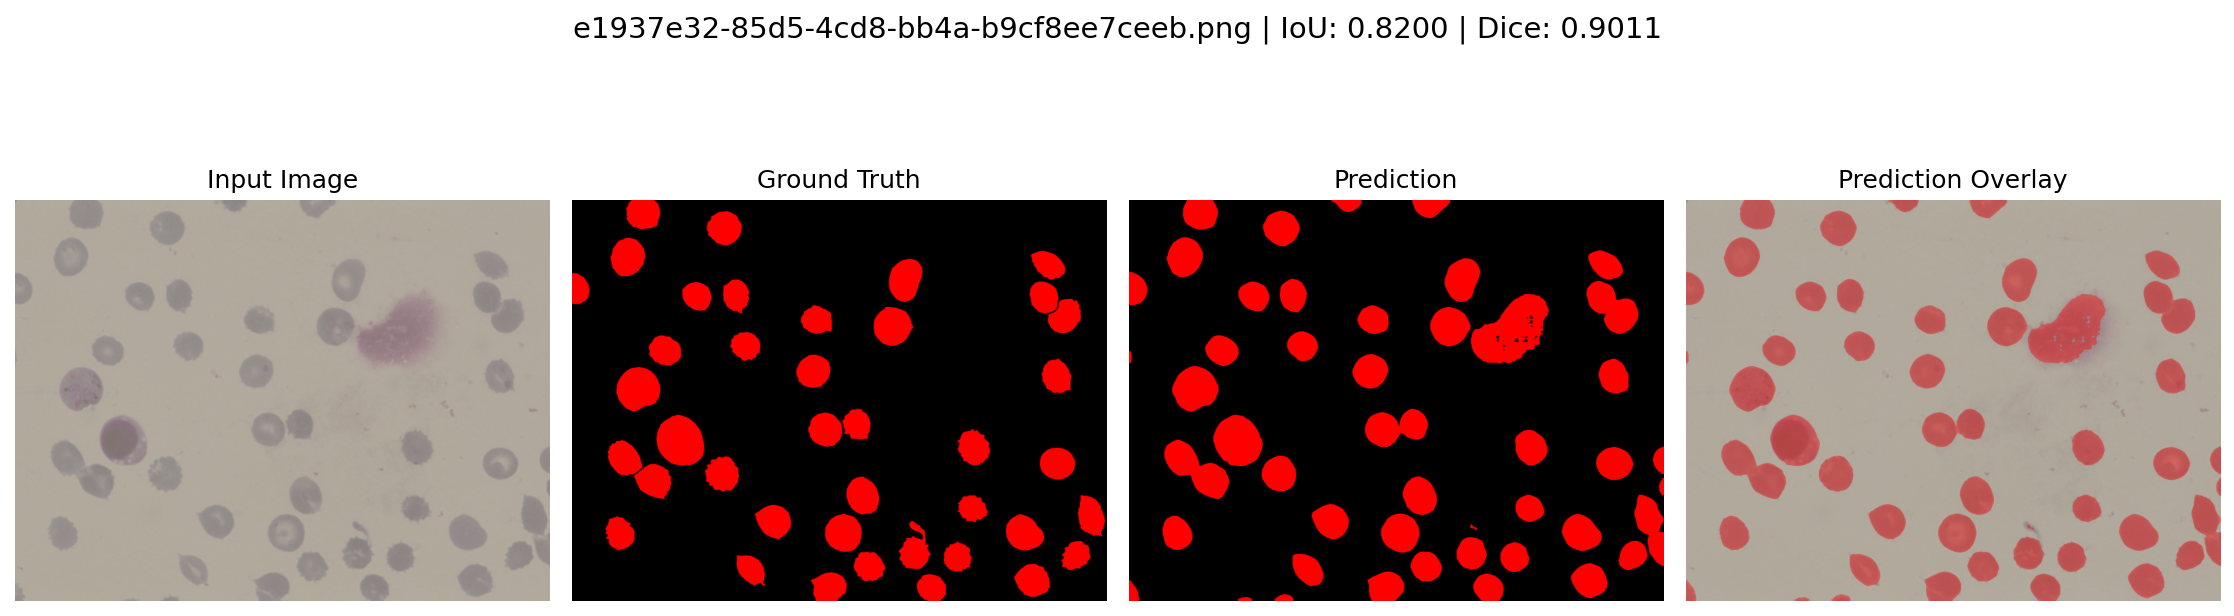

In [27]:
# Display pre-trained visualizations
from IPython.display import display, Image as IPImage

vis_dir = PRETRAINED_DIR / "evaluation" / "visualizations"

if vis_dir.exists():
    print("Success Case (High Dice: 0.9761):")
    display(IPImage(filename=str(vis_dir / "e3ade58d-086c-47fa-9120-76beacb45395_pred.png"), width=800))

    print("\nChallenging Case (Lower Dice: 0.9011):")
    display(IPImage(filename=str(vis_dir / "e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb_pred.png"), width=800))
else:
    print(f"Visualizations not found at {vis_dir}")

Training Curves:


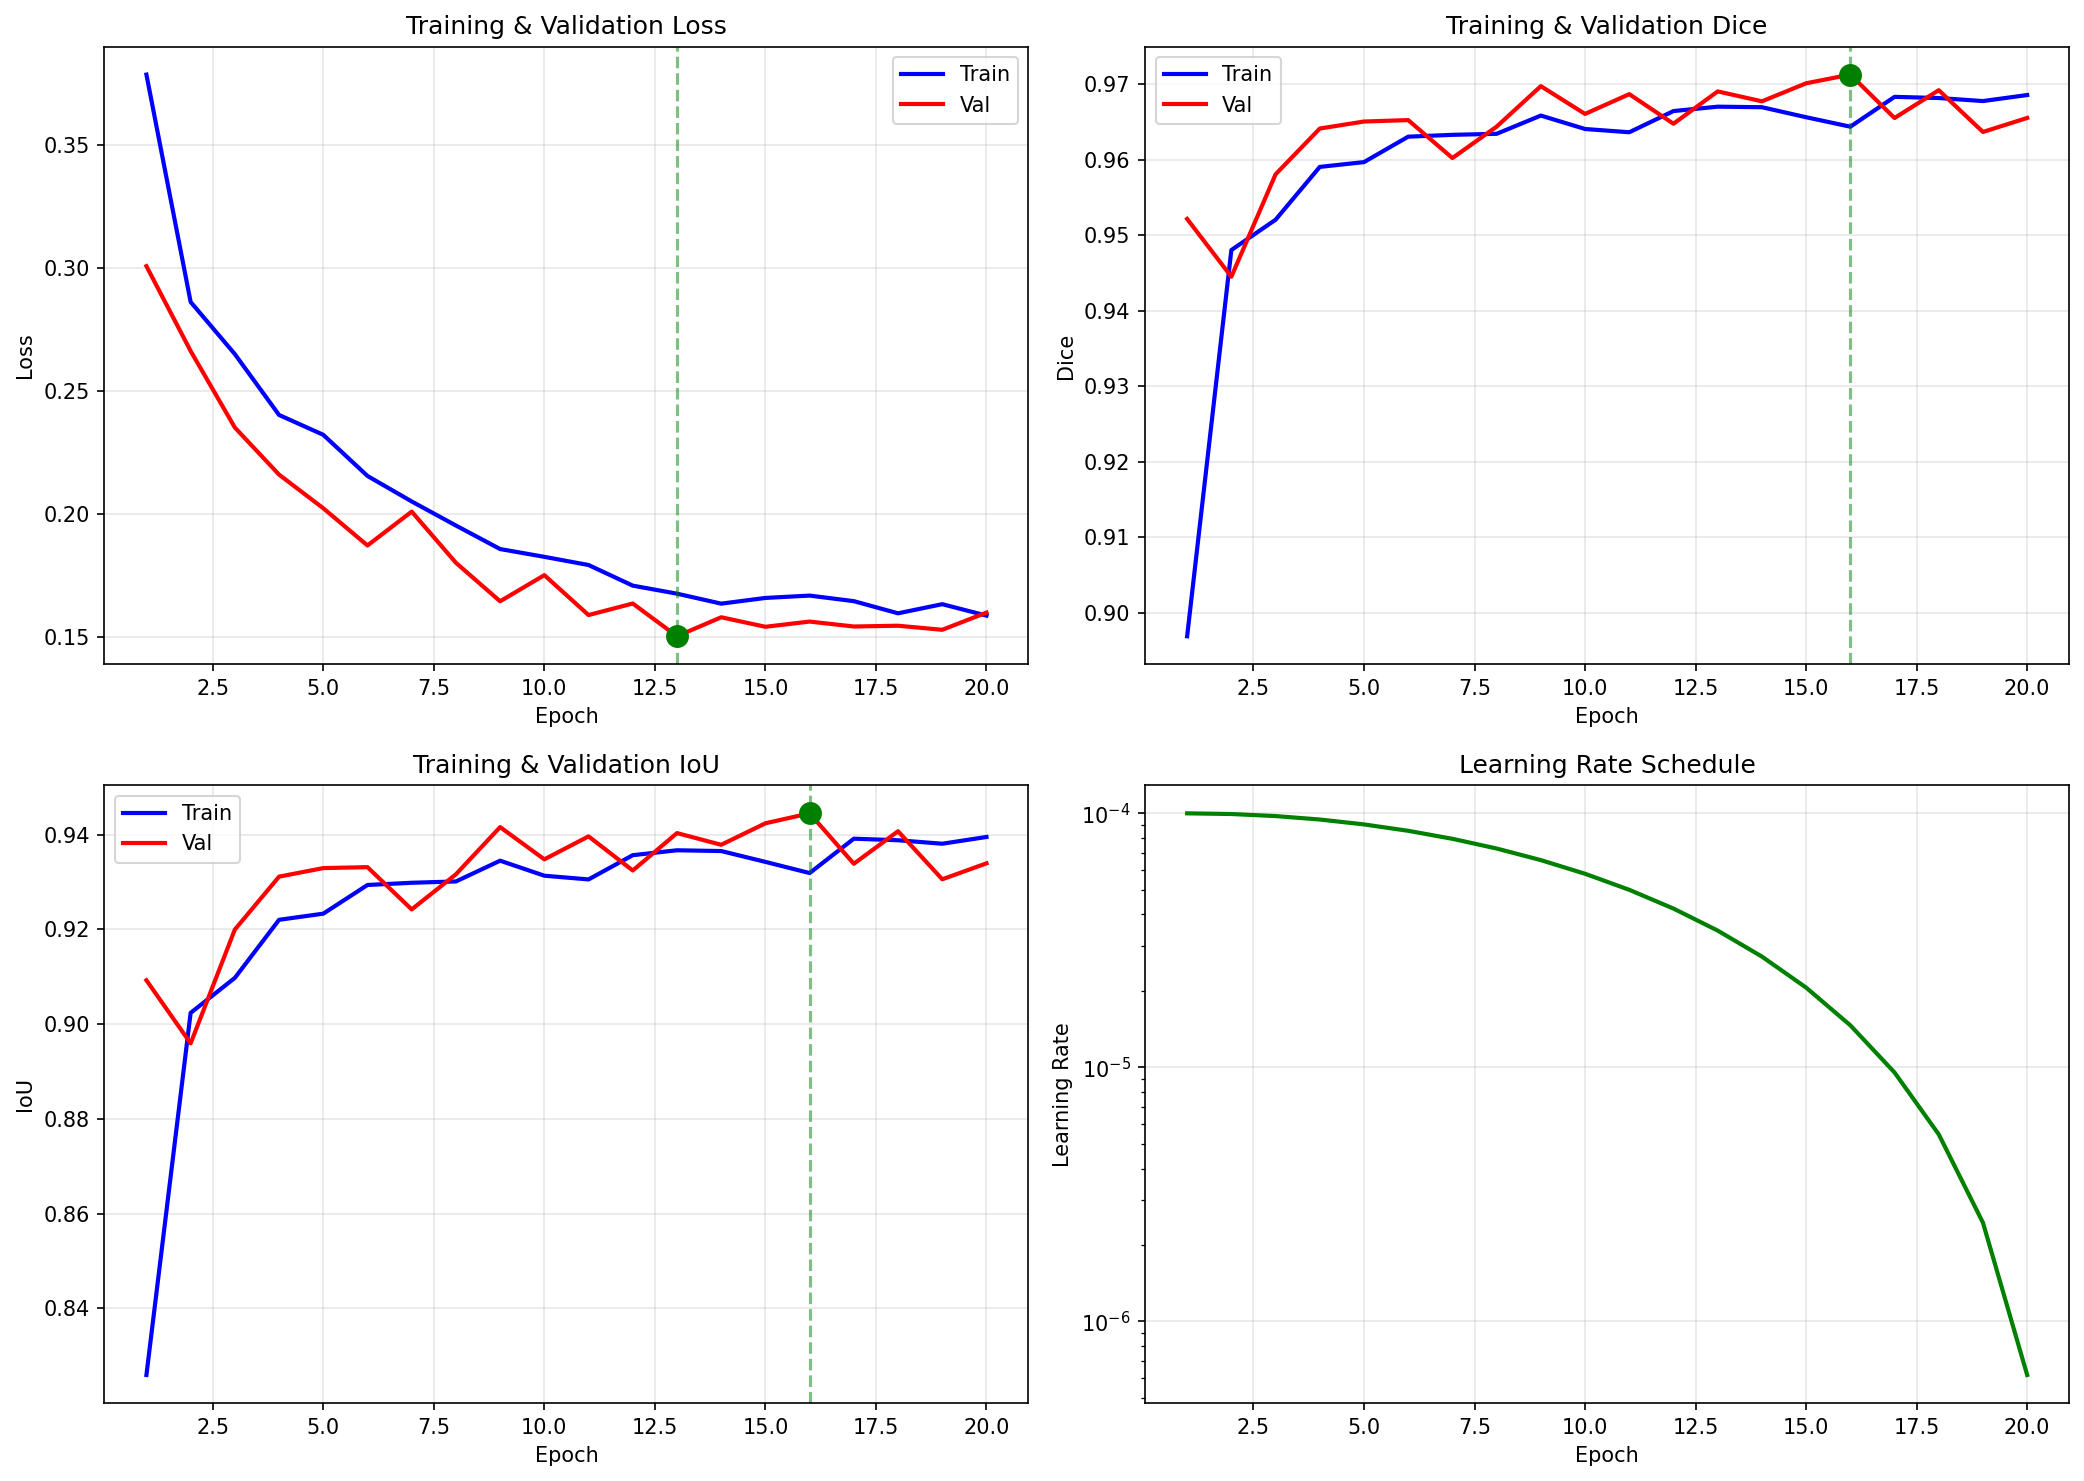

In [28]:
# Display pre-trained training curves
training_curves_path = PRETRAINED_DIR / "training_curves.png"
if training_curves_path.exists():
    print("Training Curves:")
    display(IPImage(filename=str(training_curves_path), width=800))
else:
    print(f"Training curves not found at {training_curves_path}")

Key Results (Pre-trained Model)
| Metric | Value |
|--------|-------|
| Cell IoU | 0.9112 |
| Cell Dice | 0.9536 |
| Precision | 0.9396 |
| Recall | 0.9680 |

The model achieves strong segmentation performance by leveraging domain-specific pre-trained features from DinoBloom.